_____________________________________________
# **I. Môi trường triển khai và thư viện**
_____________________________________________
* Kết nối google drive
* Link dẫn đến data
* Import các thư viện cần thiết (bao gồm các thư viện cơ bản, xử lý văn bản, học máy thông thường, học sâu,...)

In [2]:
##Kết nối google drive
#---------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
##Link folder chứa data
#---------------------------------------
folder = '/content/drive/MyDrive/UEH/Năm 3/HKC - 2024/Xử lý ngôn ngữ tự nhiên/NLP_Final /Data'

In [4]:
##Install pyvi
#---------------------------------------
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.4 MB/s eta 0:00:00


In [5]:
##Install bertopic
#---------------------------------------
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [6]:
##Import các thư viện cần thiết
#---------------------------------------
##Các thư viện cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import warnings
warnings.filterwarnings('ignore')

##Thư viện trực quan hóa
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud               #WordCloud để hiển thị trực quan các từ khóa quan trọng của chủ đề

##Thư viện xử lý văn bản
import nltk
import re
import string
from pyvi import ViTokenizer

##Thư viện học máy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Tạo ma trận đặc trưng từ văn bản
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

##Thư viện học sâu
from bertopic import BERTopic
import gensim
from gensim import corpora
from gensim.models import CoherenceModel


_____________________________________________
# **II. Phân tích EDA**
_____________________________________________

### 1. Tổng quan bộ về bộ dữ liệu
* Tổng số dòng record: Xác định kích thước dữ liệu
* Phân phối độ dài các confession

In [7]:
#Tải dữ liệu
#---------------------------------------
cfs = pd.read_excel(folder + '/CleanData.xlsx', header = None)
#cfs = pd.read_excel('CleanData.xlsx', header = None)
cfs.head()

,0
0,"Chào các anh chị, em là một người may mắn mùa ..."
1,Mình cần tìm thông tin em tênngười niên khóa 5...
2,Dạ em chào các cư dân của UEH confessions ạ! M...
3,Mình muốn nói là mình thấy bạn tênngười niên k...
4,Cho em hỏi trường mình có ai đang ở kí túc xá ...


In [8]:
#Xác định kích thước dữ liệu
#---------------------------------------
print(f'Kích thước dữ liệu: {cfs.shape}')

Kích thước dữ liệu: (400, 1)


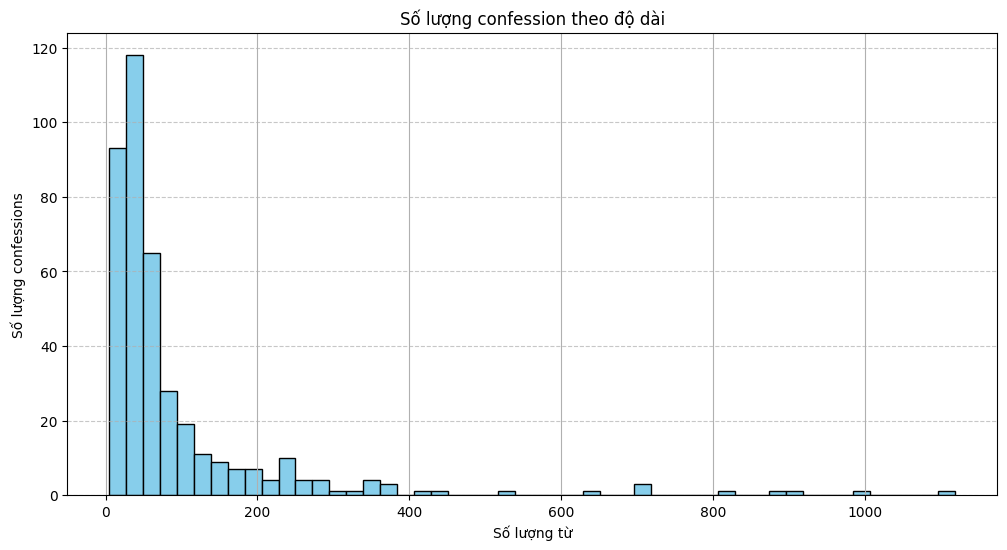

In [9]:
#Số lượng confession theo độ dài
#---------------------------------------
cfs['word_count'] = cfs[0].apply(lambda x: len(str(x).split()))
plt.figure(figsize = (14, 6))
cfs['word_count'].hist(bins = 50, figsize = (12, 6), color = 'skyblue', edgecolor = 'k')
plt.title('Số lượng confession theo độ dài')
plt.grid(axis='y', linestyle = '--', alpha = 0.7)
plt.xlabel('Số lượng từ')
plt.ylabel('Số lượng confessions')
plt.show()

### 2. Phân tích từ khóa và nội dung
* Tần số các từ phổ biến nhất
* Trực quan hóa tần số từ khóa (sử dụng WordCloud)

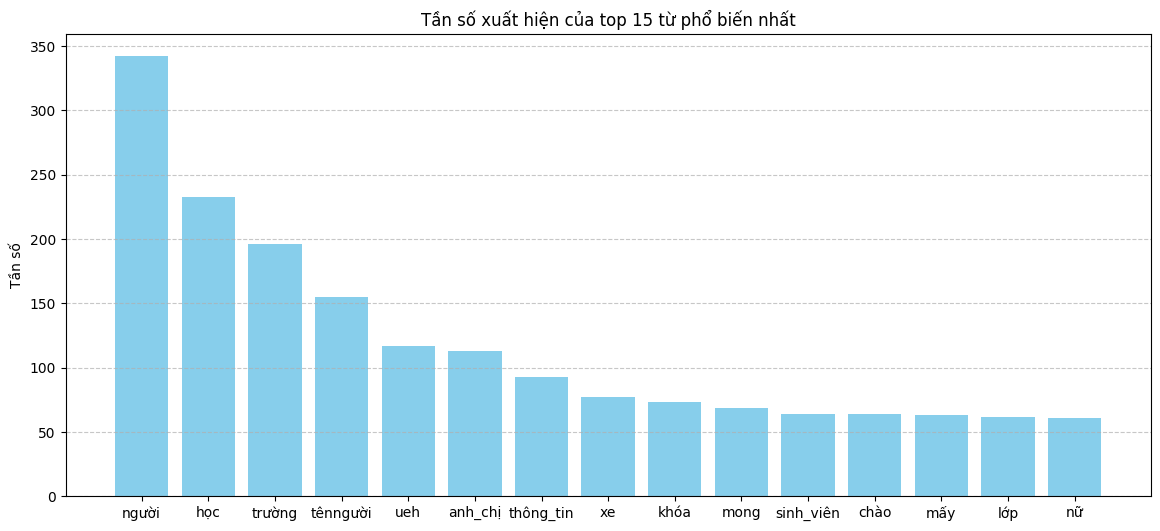

In [10]:
#Xóa stopwords tạm thời để xem tần số các từ phổ biến nhất
#---------------------------------------
vietnamese_stopwords = open(folder + '/vietnamese-stopwords-dash.txt', 'r', encoding = 'utf-8')
vietnamese_stopwords = vietnamese_stopwords.read().split('\n')

all_cfs = ' '.join(cfs[0])
all_cfs = ViTokenizer.tokenize(all_cfs)
all_cfs = re.sub(r'\d+', '', all_cfs)

#Dùng CountVectorizer để loại bỏ stopwords
vectorizer = CountVectorizer(stop_words = vietnamese_stopwords)
x = vectorizer.fit_transform([all_cfs])

#Tạo dataframe tính tần số của từ
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'freq': x.toarray().sum(axis=0)})
word_freq = word_freq.sort_values(by = 'freq', ascending = False)

#Vẽ biểu đồ tần số
plt.figure(figsize = (14, 6))
plt.bar(word_freq['word'][:15], word_freq['freq'][:15], color = 'skyblue')
plt.title('Tần số xuất hiện của top 15 từ phổ biến nhất')
plt.ylabel('Tần số')
plt.grid(axis='y', linestyle = '--', alpha = 0.7)
plt.show()

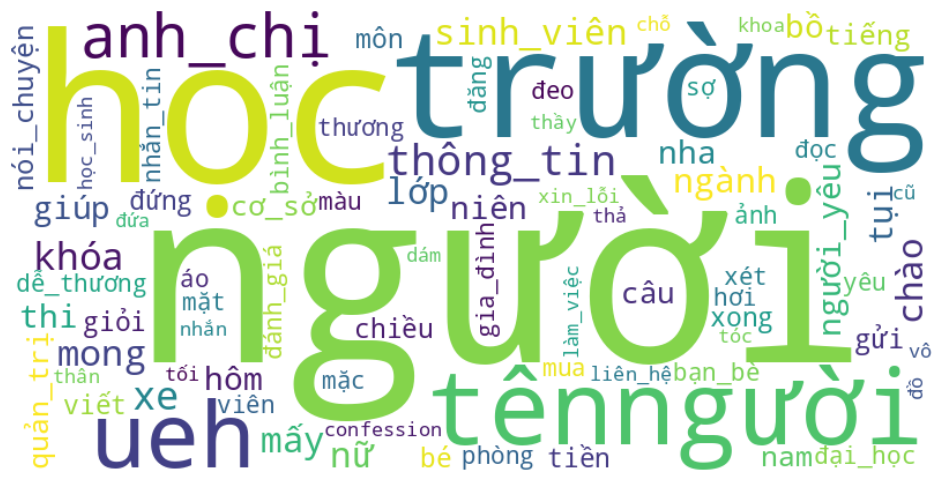

In [11]:
#Trực quan hóa tần số từ khóa bằng WordCloud
#---------------------------------------
word_freq_dict = dict(zip(word_freq['word'], word_freq['freq']))
wordcloud = WordCloud(width = 800, height = 400,max_words=80, background_color = 'white').generate_from_frequencies(word_freq_dict)
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

_____________________________________________
# **III. Tiền xử lý dữ liệu**
_____________________________________________

### **1.Chuyển văn bản thành chữ thường**


In [12]:
cfs_str = cfs[0].apply(lambda x: [x.lower()]).tolist()
cfs_str

[['chào các anh chị, em là một người may mắn mùa hè năm ngoái được trải nghiệm mùa hè xanh cùng các anh chị (em không nhớ các anh chị khóa nào) nhưng em vẫn nhớ như in các tên thân thiết của anh chị như tênngười, tênngười, tênngười, tênngười, tênngười, tênngười, tênngười, tênngười, tênngười,... tuy không học cùng nhưng em cảm nhận anh chị như gia đình của em, mọi người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh chị nhé. em thấy được những sự cố gắng, không ngừng vươn lên để đậu vô trường ueh qua lời kể của từng cá nhân anh chị. mặc dù chỉ là một người ngoài có cơ hội được gặp nhưng em lại được đặt cho 1 cái tên "tênngười" thật sự thì cái tên đó đã khắc ghi vào trong tâm trí em và cũng không quên lời nói của tênngười: "em cứ cố gắng học nha! ueh luôn chờ em" tuy chỉ là 1 câu ngắn gọn nhưng đó là động lực bấy lâu nay của em. hi vọng 1 ngày nào đó không xa em sẽ được lại mọi người!!!'],
 ['mình cần tìm thông tin em tênngười niên khóa 50 học bên khoa kế - kiểm ạ '],
 ['dạ em 

### **2. Loại bỏ dấu câu, số, xuống dòng**

In [13]:
def clean_cfs(sentence):
  # Thay xuống dòng \n bằng khoảng trắng
  sentence = sentence.replace('\n', ' ')

  # Loại bỏ dấu câu và thay bằng dấu cách
  sentence = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)

  # Loại bỏ dấu ngoặc kép “ và ” (các dấu ngoặc kép tiếng Việt)
  sentence = re.sub(r'[“”]', ' ', sentence)

  # Loại bỏ số và thay bằng dấu cách
  sentence = re.sub(r'\d+', ' ', sentence)

  # Loại bỏ các chữ cái đơn lẻ và thay bằng dấu cách
  sentence = re.sub(r'\b[a-z]\b', ' ', sentence)

  # Loại bỏ khoảng trắng thừa
  sentence = re.sub(r'\s+', ' ', sentence).strip()

  return sentence


In [14]:
cleaned_cfs = []
for sentence_list in cfs_str:
  if isinstance(sentence_list, list):
    for sentence in sentence_list:
      sentence = clean_cfs(sentence)
      cleaned_cfs.append([sentence])

print(cleaned_cfs)

[['chào các anh chị em là một người may mắn mùa hè năm ngoái được trải nghiệm mùa hè xanh cùng các anh chị em không nhớ các anh chị khóa nào nhưng em vẫn nhớ như in các tên thân thiết của anh chị như tênngười tênngười tênngười tênngười tênngười tênngười tênngười tênngười tênngười tuy không học cùng nhưng em cảm nhận anh chị như gia đình của em mọi người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh chị nhé em thấy được những sự cố gắng không ngừng vươn lên để đậu vô trường ueh qua lời kể của từng cá nhân anh chị mặc dù chỉ là một người ngoài có cơ hội được gặp nhưng em lại được đặt cho cái tên tênngười thật sự thì cái tên đó đã khắc ghi vào trong tâm trí em và cũng không quên lời nói của tênngười em cứ cố gắng học nha ueh luôn chờ em tuy chỉ là câu ngắn gọn nhưng đó là động lực bấy lâu nay của em hi vọng ngày nào đó không xa em sẽ được lại mọi người'], ['mình cần tìm thông tin em tênngười niên khóa học bên khoa kế kiểm ạ'], ['dạ em chào các cư dân của ueh confessions ạ mọi n

### **3. Tách từ bằng PyVi**

In [15]:
def tokenize_cfs(cfs):
    tokenized_cfs = []
    for sentence_list in cfs:
        if isinstance(sentence_list, list):
            for sentence in sentence_list:
                tokenized_sentence = ViTokenizer.tokenize(sentence)  # Tách từ
                tokenized_cfs.append([tokenized_sentence])
    return tokenized_cfs

token = tokenize_cfs(cleaned_cfs)
print(token)

[['chào các anh_chị_em là một người may_mắn mùa hè năm_ngoái được trải nghiệm mùa hè xanh cùng các anh_chị_em không nhớ các anh_chị khóa nào nhưng em vẫn nhớ như in các tên thân_thiết của anh_chị như tênngười tênngười tênngười tênngười tênngười tênngười tênngười tênngười tênngười tuy không học cùng nhưng em cảm_nhận anh_chị như gia_đình của em mọi người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh_chị nhé em thấy được những sự_cố_gắng không ngừng vươn lên để đậu vô trường ueh qua lời kể của từng cá_nhân anh_chị mặc_dù chỉ là một người_ngoài có cơ_hội được gặp nhưng em lại được đặt cho cái tên tênngười thật_sự thì cái tên đó đã khắc_ghi vào trong tâm_trí em và cũng không quên lời_nói của tênngười em cứ cố_gắng học nha ueh luôn chờ em tuy chỉ là câu ngắn_gọn nhưng đó là động_lực bấy_lâu_nay của em hi_vọng ngày nào đó không xa em sẽ được lại mọi người'], ['mình cần tìm thông_tin em tênngười niên khóa học bên khoa kế kiểm ạ'], ['dạ em chào các cư_dân của ueh confessions ạ mọi n

### **4. Danh sách các cụm từ cần thay thế (tự dò tìm thấy từ cần thay)**

In [16]:
merge_phrases = ['giao hàng', 'bạn thân', 'niên khóa', 'nâng cao', 'tiếng anh', 'mọi người', 'trải nghiệm', 'câu lạc bộ', 'quản trị viên', 'chụp ảnh',
'tiếng trung', 'diễn giả', 'kì nghỉ', 'hiến máu', 'xét tuyển', 'giấy chứng nhận', 'lớp trưởng', 'xương máu', 'thực tập', 'trái ngành',
'bạch nguyệt quang', 'người yêu', 'ca tối', 'tóc ngắn', 'trường ueh', 'tập hát', 'giấc mộng', 'chở che', 'gửi xe', 'bình thạnh',
'thành phố hồ chí minh', 'kì thi', 'loạn nhịp', 'ẩn danh', 'khóa học', 'kết giao', 'tiếng đức', 'tân hương', 'đề thi', 'lòi lõm',
'mùa hè', 'đi làm', 'mẫu ảnh', 'tự luận', 'mùa thu', 'mối tình', 'thời khóa biểu', 'tân phú', 'cuộc thi', 'nam vương', 'tân bình',
'phú nhuận', 'mạo muội', 'đà lạt', 'hai bà trưng', 'tân định', 'hồ chí minh', 'cái tôi', 'gia định', 'trần hưng đạo', 'bất hòa',
'đồ sắt nhọn', 'anh chị', 'đi học', 'kiếp nạn', 'bài đăng', 'trường mình', 'năm nhất', 'năm hai', 'năm ba', 'năm tư', 'tiếng việt',
                 'mùa đông', 'mùa xuân', 'ba mẹ', 'tiếng pháp']

# Hàm thay thế cụm từ ghép thành từ có dấu gạch dưới
def replace_merge_phrases(cfs, merge_phrases):
    for phrase in merge_phrases:

        # Thay thế cụm từ bằng từ có dấu gạch dưới
        cfs = re.sub(rf"\b{re.escape(phrase)}\b", phrase.replace(' ', '_'), cfs)

    # Thay thế các cụm từ dạng "tênngười" và "tênlớp" thành "tên_người" và "tên_lớp"
    cfs = re.sub(r"(tên)(người|lớp)", r"\1_\2", cfs)
    return cfs

#
updated_cfs = [[replace_merge_phrases(cfs[0], merge_phrases)] for cfs in cleaned_cfs ]

#
for i, cfs in enumerate(updated_cfs):
    print(f"Cfs {i + 1}:")
    print(cfs)
    print()

Cfs 1:
['chào các anh_chị em là một người may mắn mùa_hè năm ngoái được trải_nghiệm mùa_hè xanh cùng các anh_chị em không nhớ các anh_chị khóa nào nhưng em vẫn nhớ như in các tên thân thiết của anh_chị như tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tuy không học cùng nhưng em cảm nhận anh_chị như gia đình của em mọi_người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh_chị nhé em thấy được những sự cố gắng không ngừng vươn lên để đậu vô trường_ueh qua lời kể của từng cá nhân anh_chị mặc dù chỉ là một người ngoài có cơ hội được gặp nhưng em lại được đặt cho cái tên tên_người thật sự thì cái tên đó đã khắc ghi vào trong tâm trí em và cũng không quên lời nói của tên_người em cứ cố gắng học nha ueh luôn chờ em tuy chỉ là câu ngắn gọn nhưng đó là động lực bấy lâu nay của em hi vọng ngày nào đó không xa em sẽ được lại mọi_người']

Cfs 2:
['mình cần tìm thông tin em tên_người niên_khóa học bên khoa kế kiểm ạ']

Cfs 3:
['dạ em chào các cư

### **5. Tách từ bằng PyVi (sau khi thay thế)**

In [17]:
updated_token = tokenize_cfs(updated_cfs)
print(updated_token)

[['chào các anh_chị em là một người may_mắn mùa_hè năm_ngoái được trải_nghiệm mùa_hè xanh cùng các anh_chị em không nhớ các anh_chị khóa nào nhưng em vẫn nhớ như in các tên thân_thiết của anh_chị như tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tuy không học cùng nhưng em cảm_nhận anh_chị như gia_đình của em mọi_người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh_chị nhé em thấy được những sự_cố_gắng không ngừng vươn lên để đậu vô trường_ueh qua lời kể của từng cá_nhân anh_chị mặc_dù chỉ là một người_ngoài có cơ_hội được gặp nhưng em lại được đặt cho cái tên tên_người thật_sự thì cái tên đó đã khắc_ghi vào trong tâm_trí em và cũng không quên lời_nói của tên_người em cứ cố_gắng học nha ueh luôn chờ em tuy chỉ là câu ngắn_gọn nhưng đó là động_lực bấy_lâu_nay của em hi_vọng ngày nào đó không xa em sẽ được lại mọi_người'], ['mình cần tìm thông_tin em tên_người niên_khóa học bên khoa kế kiểm ạ'], ['dạ em chào các cư_dân của ueh confess

### **6. Xóa các stopwords Tiếng Việt**




In [18]:
stopword = pd.read_csv(folder + '/vietnamese-stopwords-dash.txt',header=None)
#stopword = pd.read_csv('vietnamese-stopwords-dash.txt',header=None)
viet_stopwords = stopword[0].tolist()
print(viet_stopwords)

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy', 'ba', 'ba_ba', 'ba_bản', 'ba_cùng', 'ba_họ', 'ba_ngày', 'ba_ngôi', 'ba_tăng', 'bao_giờ', 'bao_lâu', 'bao_nhiêu', 'bao_nả', 'bay_biến', 'biết', 'biết_bao', 'biết_bao_nhiêu', 'biết_chắc', 'biết_chừng_nào', 'biết_mình', 'biết_mấy', 'biết_thế', 'biết_trước', 'biết_việc', 'biết_đâu', 'biết_đâu_chừng', 'biết_đâu_đấy', 'biết_được', 'buổi', 'buổi_làm', 'buổi_mới', 'buổi_ngày', 'buổi_sớm', 'bà', 'bà_ấy', 'bài', 'bài_bác', 'bài_bỏ', 'bài_cái', 'bác', 'bán', 'bán_cấp', 'bán_dạ', 'bán_thế', 'bây_bẩy', 'bây_chừ', 'bây_giờ', 'bây_nhiêu', 'bèn', 'béng', 'bên', 'bên_bị', 'bên_có', 'bên_cạnh', 'bông', 'bước', 'bước_khỏi', 'bước_tới', 'bước_đi', 'bạn', 'bản', 'bản_bộ', 'bản_riêng', 'bản_thân', 'bản_ý', 'bất_chợt', 'bất_cứ', 'bất_giác', 'bất_kì', 'bất_kể', 'bất_kỳ', 'bất_luận', 'bất_ngờ', 'bất_nhược', 'bất_quá', 'bất_quá_chỉ', 'bất_thình_lình', 'bất_tử', 'bất_đồ', 'bấy', 'bấy_chầy', 'bấy_chừ', 'bấy_giờ', 'bấy_lâu', 'bấy_lâ

In [19]:
#Thêm các cụm từ
add_in=['hôm', 'lắm', 'tụi', 'hu_hu','hi_hi', 'mấy', 'nha', 'đi', 'hi', 'hic','hu', 'í']
viet_stopwords.extend(add_in)

In [20]:
updated_token

[['chào các anh_chị em là một người may_mắn mùa_hè năm_ngoái được trải_nghiệm mùa_hè xanh cùng các anh_chị em không nhớ các anh_chị khóa nào nhưng em vẫn nhớ như in các tên thân_thiết của anh_chị như tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tuy không học cùng nhưng em cảm_nhận anh_chị như gia_đình của em mọi_người vẫn mở lòng bảo khi nào có bài không hiểu thì cứ hỏi anh_chị nhé em thấy được những sự_cố_gắng không ngừng vươn lên để đậu vô trường_ueh qua lời kể của từng cá_nhân anh_chị mặc_dù chỉ là một người_ngoài có cơ_hội được gặp nhưng em lại được đặt cho cái tên tên_người thật_sự thì cái tên đó đã khắc_ghi vào trong tâm_trí em và cũng không quên lời_nói của tên_người em cứ cố_gắng học nha ueh luôn chờ em tuy chỉ là câu ngắn_gọn nhưng đó là động_lực bấy_lâu_nay của em hi_vọng ngày nào đó không xa em sẽ được lại mọi_người'],
 ['mình cần tìm thông_tin em tên_người niên_khóa học bên khoa kế kiểm ạ'],
 ['dạ em chào các cư_dân của ueh confe

In [21]:
def remove_stopwords(tokens, stopwords):
    return [token for token in tokens if token not in stopwords]

# Áp dụng hàm loại bỏ stopwords cho từng cfs trong updated_cfs
processed_cfs = []

for cfs in updated_token:
    tokens = cfs[0].split()  # Tách chuỗi thành các từ
    filtered_tokens = remove_stopwords(tokens, viet_stopwords)  # Loại bỏ stopwords
    processed_cfs.append([filtered_tokens])
# In kết quả
for i, cfs in enumerate(processed_cfs):
    print(f"Cfs {i + 1}:")
    print(' '.join(cfs[0]))  # Hiển thị lại văn bản sau khi loại bỏ stopwords
    print()

Cfs 1:
chào anh_chị người may_mắn mùa_hè năm_ngoái trải_nghiệm mùa_hè xanh anh_chị anh_chị khóa in thân_thiết anh_chị tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người học cảm_nhận anh_chị gia_đình bảo anh_chị sự_cố_gắng ngừng vươn đậu vô trường_ueh anh_chị người_ngoài tên_người khắc_ghi tâm_trí quên tên_người cố_gắng học ueh chờ câu ngắn_gọn động_lực hi_vọng

Cfs 2:
thông_tin tên_người niên_khóa học khoa kế kiểm

Cfs 3:
chào cư_dân ueh confessions thông_tin chụp_ảnh ueh mentoring training chụp_ảnh đẹp xỉu

Cfs 4:
tên_người niên_khóa quản_lý công đẹp_trai người_thương đón noel

Cfs 5:
trường_mình kí_túc_xá bách_khoa

Cfs 6:
chào anh_chị học ueh tiếng_anh bình_thường hơi ielts tầm hứng_thú tiếng_trung học tiếng_trung chán_nản học tiếng_anh học khuyên duy_trì tiếng_anh ôn ráng tập_trung_học tiếng_trung học tiếng_anh tiếng_trung học quyết_định tiếng_anh ngôn_ngữ việc_làm ngôn_ngữ anh_chị

Cfs 7:
kinh_nghiệm kiến_thức lĩnh_vực tổ_chức talkshow diễn_g

In [22]:
processed_cfs

[[['chào',
   'anh_chị',
   'người',
   'may_mắn',
   'mùa_hè',
   'năm_ngoái',
   'trải_nghiệm',
   'mùa_hè',
   'xanh',
   'anh_chị',
   'anh_chị',
   'khóa',
   'in',
   'thân_thiết',
   'anh_chị',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'tên_người',
   'học',
   'cảm_nhận',
   'anh_chị',
   'gia_đình',
   'bảo',
   'anh_chị',
   'sự_cố_gắng',
   'ngừng',
   'vươn',
   'đậu',
   'vô',
   'trường_ueh',
   'anh_chị',
   'người_ngoài',
   'tên_người',
   'khắc_ghi',
   'tâm_trí',
   'quên',
   'tên_người',
   'cố_gắng',
   'học',
   'ueh',
   'chờ',
   'câu',
   'ngắn_gọn',
   'động_lực',
   'hi_vọng']],
 [['thông_tin', 'tên_người', 'niên_khóa', 'học', 'khoa', 'kế', 'kiểm']],
 [['chào',
   'cư_dân',
   'ueh',
   'confessions',
   'thông_tin',
   'chụp_ảnh',
   'ueh',
   'mentoring',
   'training',
   'chụp_ảnh',
   'đẹp',
   'xỉu']],
 [['tên_người',
   'niên_khóa',
   'quản_lý',
   'công',
   'đẹ

In [23]:
# Chuyển processed_cfs thành một danh sách các chuỗi
flattened_cfs = [' '.join(cfs[0]) for cfs in processed_cfs]

# Chuyển thành DataFrame
df = pd.DataFrame(flattened_cfs, columns=["Processed_Text"])

df

,Processed_Text
0,chào anh_chị người may_mắn mùa_hè năm_ngoái tr...
1,thông_tin tên_người niên_khóa học khoa kế kiểm
2,chào cư_dân ueh confessions thông_tin chụp_ảnh...
3,tên_người niên_khóa quản_lý công đẹp_trai ngườ...
4,trường_mình kí_túc_xá bách_khoa
...,...
395,đề_tài_chính doanh_nghiệp sốc kinh_khủng học c...
396,xấu chào nữ_sinh_viên người_yêu đọc tiêu_đề tò...
397,anh_chị khoa quản_lí nhà_nước khoa tổ_chức hội...
398,tự_luận kinh_tế vĩ_mô chém đọc sách xong mơ_hồ


_____________________________________________
# **IV. Phân cụm văn bản (Topic Modelling)**
_____________________________________________

### **1. Vector hóa văn bản**



*   Tfidf cấp độ 'word'
*   max_features=50



In [24]:
# Vector hóa văn bản bằng TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=50)
X_tfidf = tfidf_vectorizer.fit_transform(df['Processed_Text'])

# Kiểm tra kích thước ma trận TF-IDF
print(X_tfidf.shape)

(400, 50)


### **2. Mô hình học máy**

#### **LDA**

Các bước thực hiện:


1.   Chọn n_components (số topics) phù hợp bằng cách vẽ biểu đồ Perlexity.
2.   Xây dựng mô hình LDA với n vừa chọn. Tìm ra các chủ đề.
3. Biểu diễn trực quan bằng Wordcloud để quan sát các từ ngữ phổ biến (đặc trưng) của mỗi chủ đề.
4. Gán nhãn cho mỗi cfs theo một ngưỡng xác suất. Thêm cột nhãn vào df
5. Biểu diễn số lượng cfs cho mỗi chủ đề bằng biểu đồ cột.
6. Tính các chỉ số  Perlexity, Davies-Bouldin Index và Silhouette Score (chỉ tính trên các cfs thuộc chủ đề đã phân chia)
7. Biểu diễn trực quan bằng TSNE.


n_components=2: Perplexity=58.52133919080567
n_components=3: Perplexity=72.61728526340376
n_components=4: Perplexity=84.39908772419625
n_components=5: Perplexity=104.23788290691981
n_components=7: Perplexity=129.9907988231805
n_components=10: Perplexity=169.63352617131744
n_components=15: Perplexity=249.7970608787999
n_components=20: Perplexity=351.3046610146192


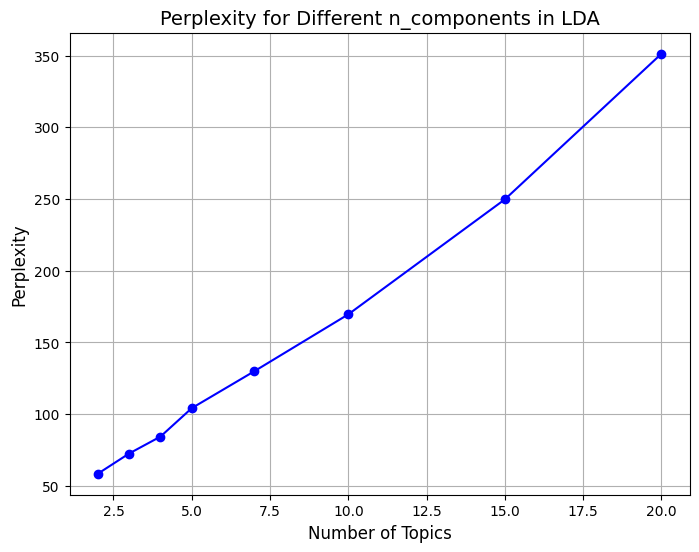

In [25]:
n_components_list = [2, 3, 4, 5, 7, 10, 15, 20]
perplexities = []

# Chạy mô hình LDA với các giá trị n_components khác nhau và tính Perplexity
for n in n_components_list:
    lda = LDA(n_components=n, random_state=42)
    lda_topics = lda.fit_transform(X_tfidf)

    # Tính Perplexity
    perplexity = lda.perplexity(X_tfidf)
    perplexities.append(perplexity)

    print(f"n_components={n}: Perplexity={perplexity}")

# Vẽ đồ thị Perplexity
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, perplexities, marker='o', linestyle='-', color='b')
plt.title('Perplexity for Different n_components in LDA', fontsize=14)
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Perplexity', fontsize=12)
plt.grid(True)
plt.show()

*=> Chọn n_components=3 có Perlexity thấp và số cụm không quá nhỏ*

In [26]:
# Tạo mô hình LDA với n_components=3
lda = LDA(n_components=3, random_state=42)
lda_topics = lda.fit_transform(X_tfidf)
# Lấy các từ từ TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Hiển thị các chủ đề từ mô hình LDA
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx}:")
    print([feature_names[i] for i in topic.argsort()[-15:]])


Topic #0:
['giỏi', 'mong', 'dễ_thương', 'xong', 'đeo', 'tiền', 'gửi', 'lớp', 'chiều', 'cơ_sở', 'xe', 'người', 'niên_khóa', 'thông_tin', 'tên_người']
Topic #1:
['bạn_bè', 'gia_đình', 'thương', 'đọc', 'mặc', 'áo', 'viết', 'yêu', 'bé', 'sinh_viên', 'ueh', 'bình_luận', 'mua', 'người', 'người_yêu']
Topic #2:
['nhắn_tin', 'quản_trị_viên', 'đại_học', 'mong', 'đánh_giá', 'thi', 'giúp', 'nữ', 'ueh', 'ngành', 'chào', 'trường_mình', 'trường', 'anh_chị', 'học']


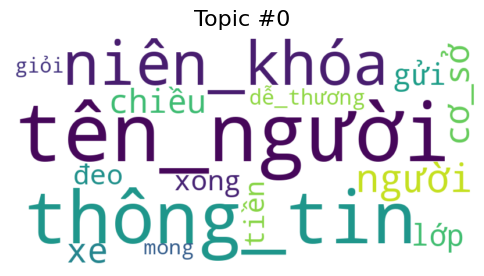

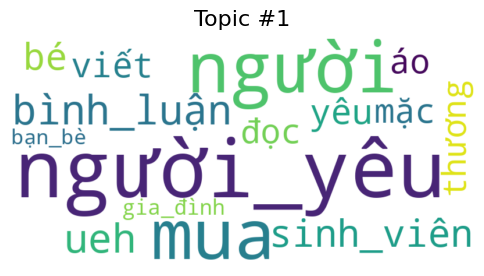

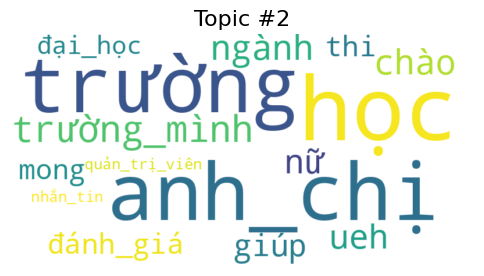

In [27]:
# Vẽ WordCloud cho từng chủ đề
for idx, topic in enumerate(lda.components_):
    # Chọn 15 từ quan trọng nhất trong mỗi chủ đề
    topic_words = [feature_names[i] for i in topic.argsort()[-15:]]

    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-15:]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{idx}", fontsize=16)
    plt.show()


In [28]:
# Tạo df mới đề phân các cfs vào các chủ đề/ cụm
cfs_topic = df.copy()

print(cfs_topic.head())

                                      Processed_Text
0  chào anh_chị người may_mắn mùa_hè năm_ngoái tr...
1     thông_tin tên_người niên_khóa học khoa kế kiểm
2  chào cư_dân ueh confessions thông_tin chụp_ảnh...
3  tên_người niên_khóa quản_lý công đẹp_trai ngườ...
4                    trường_mình kí_túc_xá bách_khoa


In [29]:
#Đặt ngưỡng xác suất
threshold = 0.3

# Tạo cột 'LDA_Topics' để gắn các nhãn chủ đề cho cfs
cfs_topic['LDA_Topics'] =  [
    max(
        [(i, prob) for i, prob in enumerate(doc_probs) if prob > threshold],
        key=lambda x: x[1],  # Lấy topic có xác suất cao nhất
        default=(-1, 0)  # Nếu không có topic nào vượt ngưỡng, trả về -1
    )[0]
    for doc_probs in lda_topics
]
#
print(cfs_topic[['Processed_Text', 'LDA_Topics']].head())


                                      Processed_Text  LDA_Topics
0  chào anh_chị người may_mắn mùa_hè năm_ngoái tr...           0
1     thông_tin tên_người niên_khóa học khoa kế kiểm           0
2  chào cư_dân ueh confessions thông_tin chụp_ảnh...           2
3  tên_người niên_khóa quản_lý công đẹp_trai ngườ...           0
4                    trường_mình kí_túc_xá bách_khoa           2


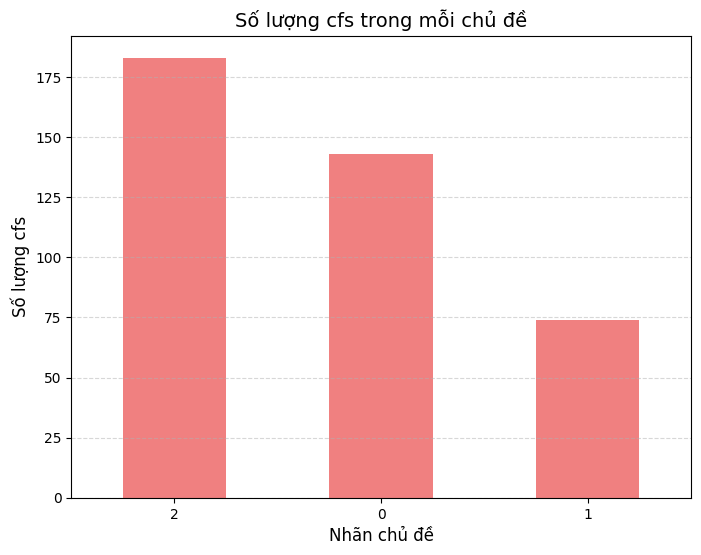

LDA_Topics
2    183
0    143
1     74
Name: count, dtype: int64


In [30]:
# Tính số lượng văn bản theo các nhãn chủ đề
topic_label_counts = cfs_topic['LDA_Topics'].value_counts()

# Vẽ biểu đồ s
plt.figure(figsize=(8, 6))
topic_label_counts.plot(kind='bar', color='lightcoral')
plt.title('Số lượng cfs trong mỗi chủ đề', fontsize=14)
plt.xlabel('Nhãn chủ đề', fontsize=12)
plt.ylabel('Số lượng cfs', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# In số lượng
print(topic_label_counts)


*=> Ở ngưỡng xác suất 0.3, tất cả cfs đều thuộc 1 (hoặc nhiều) chủ đề*

In [31]:
# Tính Perplexity
perplexityLDA = lda.perplexity(X_tfidf)

# Tính Davies-Bouldin Index
davies_bouldinLDA = davies_bouldin_score(X_tfidf.toarray(),cfs_topic['LDA_Topics'] )

# Tính Silhouette Score
silhouetteLDA = silhouette_score(X_tfidf,cfs_topic['LDA_Topics'] )

# In kết quả
print(f"LDA  - topics = 3:")
print(f"  Perplexity: {perplexityLDA}")
print(f"  Silhouette Score: {silhouetteLDA}")
print(f"  Davies-Bouldin Index: {davies_bouldinLDA}")

LDA  - topics = 3:
  Perplexity: 72.61728526340376
  Silhouette Score: 0.04317495311162285
  Davies-Bouldin Index: 4.443593165162677


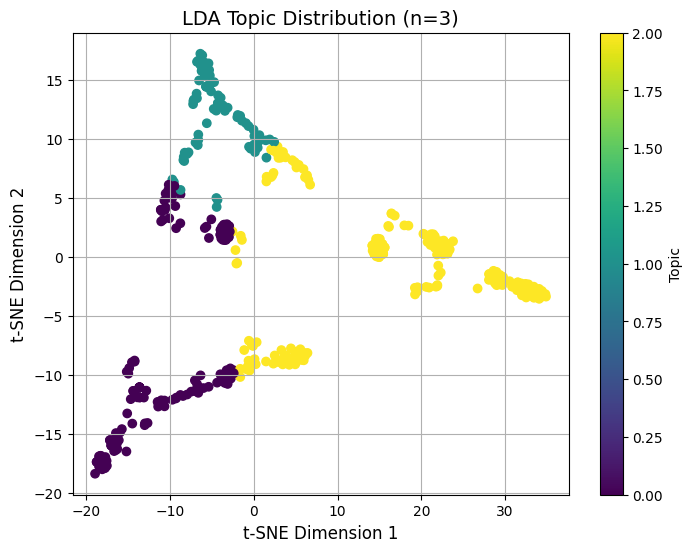

In [32]:
# Tạo TSNE
tsne = TSNE(n_components=2, random_state=42)
lda_tsne = tsne.fit_transform(lda_topics)

# Trực quan hóa kết quả TSNE
plt.figure(figsize=(8, 6))
plt.scatter(lda_tsne[:, 0], lda_tsne[:, 1], c=cfs_topic['LDA_Topics'], cmap='viridis', marker='o')
plt.title('LDA Topic Distribution (n=3)', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(label='Topic')
plt.grid(True)
plt.show()


#### **Non-negative Matrix Factorization (NMF)**

Các bước thực hiện:


1.   Chọn n_components (số topics) phù hợp bằng cách vẽ biểu đồ Perlexity và chọn n có Perlexity thấp.
2.   Xây dựng mô hình với n vừa chọn. Tìm ra các chủ đề.
3. Gán nhãn cho mỗi cfs bằng cách chọn chủ đề mà cfs có xác suất thuộc vào cao nhất (>0.12). Thêm cột nhãn vào df
4. Biểu diễn số lượng cfs cho mỗi chủ đề bằng biểu đồ cột.
5. Tính các chỉ số  Perlexity, Davies-Bouldin Index và Silhouette Score.
6. Biểu diễn trực quan bằng TSNE.


n_components=5: Perplexity=16.06315566631654
n_components=15: Perplexity=12.4219446628687
n_components=20: Perplexity=10.921671832798104
n_components=25: Perplexity=9.46030993281828
n_components=30: Perplexity=8.064232167530605
n_components=35: Perplexity=6.459020137474575
n_components=40: Perplexity=4.854066610686441
n_components=50: Perplexity=1.080302135694735


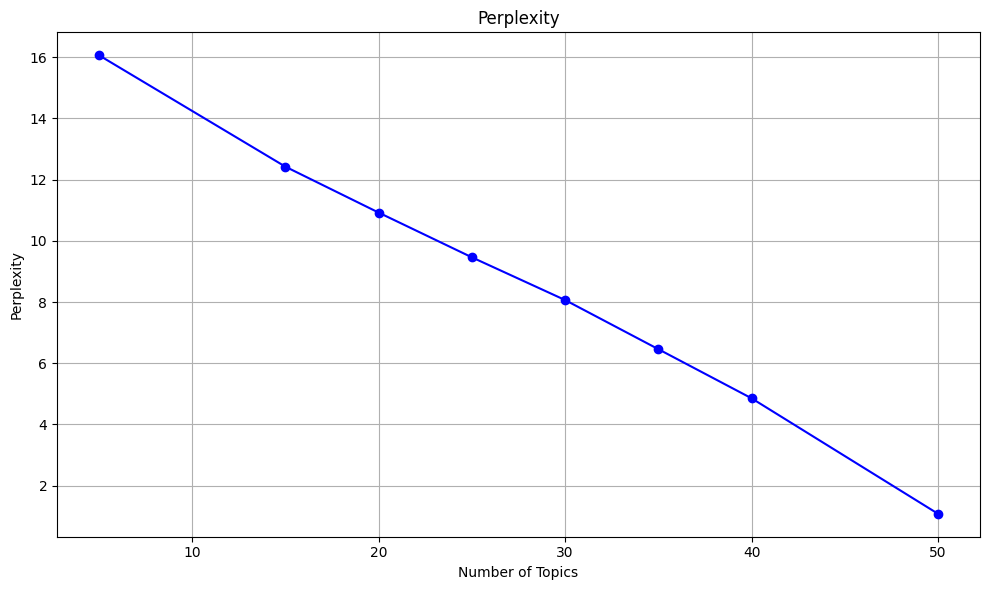

In [33]:
n_components_list = [5, 15, 20,  25 ,30, 35, 40, 50]

perplexitiesNMF = []

# Chạy mô hình NMF với các giá trị n_components khác nhau
for n in n_components_list:
    nmf = NMF(n_components=n, random_state=42)
    nmf_topics = nmf.fit_transform(X_tfidf)

    # Tính Perplexity
    perplexity = nmf.reconstruction_err_
    perplexitiesNMF.append(perplexity)
    print(f"n_components={n}: Perplexity={perplexity}")

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, perplexitiesNMF, marker='o', linestyle='-', color='b')
plt.title('Perplexity', fontsize=12)
plt.xlabel('Number of Topics', fontsize=10)
plt.ylabel('Perplexity', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

*Số lượng topics càng cao, Perlexity càng giảm. Chọn n = 20 ở mức vừa phải*

In [34]:
# Chọn n=20
nmf = NMF(n_components=20, random_state=42)
nmf_topics = nmf.fit_transform(X_tfidf)

# Hiển thị các chủ đề
for idx, topic in enumerate(nmf.components_):
    print(f"\nTopic #{idx}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #0:
['đọc', 'hơi', 'thương', 'bình_luận', 'đại_học', 'dễ_thương', 'nhắn_tin', 'xong', 'chào', 'anh_chị']

Topic #1:
['dễ_thương', 'mong', 'hơi', 'yêu', 'bồ', 'thông_tin', 'môn', 'tiền', 'gửi', 'tên_người']

Topic #2:
['gia_đình', 'xong', 'yêu', 'đại_học', 'nói_chuyện', 'bạn_bè', 'đọc', 'viết', 'giỏi', 'người']

Topic #3:
['nói_chuyện', 'viết', 'gia_đình', 'bình_luận', 'đọc', 'phòng', 'môn', 'cơ_sở', 'đại_học', 'học']

Topic #4:
['đại_học', 'quản_trị_viên', 'nam', 'áo', 'đứng', 'dễ_thương', 'mặc', 'đeo', 'chiều', 'thông_tin']

Topic #5:
['bạn_bè', 'hơi', 'viết', 'đại_học', 'mong', 'nhắn_tin', 'tiền', 'yêu', 'áo', 'trường']

Topic #6:
['mặc', 'nói_chuyện', 'quản_trị_viên', 'bình_luận', 'gửi', 'đại_học', 'hơi', 'giỏi', 'chào', 'ueh']

Topic #7:
['gửi', 'đứng', 'mặt', 'học', 'hơi', 'yêu', 'tiền', 'nói_chuyện', 'chào', 'trường_mình']

Topic #8:
['môn', 'mặt', 'quản_trị_viên', 'bồ', 'xong', 'gửi', 'nhắn_tin', 'nam', 'chào', 'niên_khóa']

Topic #9:
['chiều', 'nói_chuyện', 'tiền', 'mặc'

In [35]:
threshold = 0.12

# Tạo cột
cfs_topic['NMF_Topics'] = [
    max(
        [(i, prob) for i, prob in enumerate(doc_probs) if prob > threshold],
        key=lambda x: x[1],  # Lấy topic có xác suất cao nhất
        default=(-1, 0)  # Nếu không có topic nào vượt ngưỡng, trả về -1
    )[0]
    for doc_probs in nmf_topics
]
#
print(cfs_topic[['Processed_Text', 'NMF_Topics']].head())



                                      Processed_Text  NMF_Topics
0  chào anh_chị người may_mắn mùa_hè năm_ngoái tr...           1
1     thông_tin tên_người niên_khóa học khoa kế kiểm           1
2  chào cư_dân ueh confessions thông_tin chụp_ảnh...           6
3  tên_người niên_khóa quản_lý công đẹp_trai ngườ...           1
4                    trường_mình kí_túc_xá bách_khoa           7


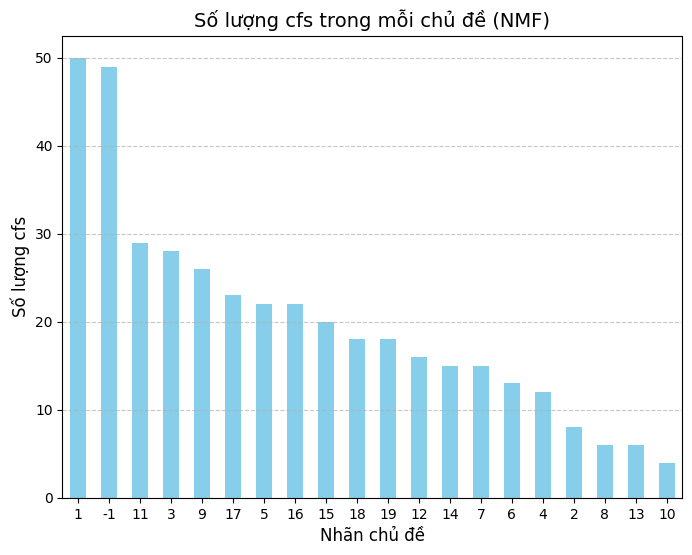

In [36]:
# Tính số lượng văn bản theo các nhãn
topic_label_counts = cfs_topic['NMF_Topics'] .value_counts()

# Vẽ biểu đồ số lượng văn bản theo từng nhãn
plt.figure(figsize=(8, 6))
topic_label_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng cfs trong mỗi chủ đề (NMF)', fontsize=14)
plt.xlabel('Nhãn chủ đề', fontsize=12)
plt.ylabel('Số lượng cfs', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [37]:
# Tính Perplexity
PerplexityNMF = nmf.reconstruction_err_

# Tính Silhouette Score
silhouetteNMF = silhouette_score(X_tfidf, cfs_topic['NMF_Topics'])

# Tính Davies-Bouldin IndexF
davies_bouldinNMF= davies_bouldin_score(X_tfidf.toarray(), cfs_topic['NMF_Topics'])

# In ra kết quả
print(f"NFM  - topics = 20:")
print(f"Perplexity: {PerplexityNMF}")
print(f"Silhouette Score: {silhouetteNMF}")
print(f"Davies-Bouldin Index: {davies_bouldinNMF}")


NFM  - topics = 20:
Perplexity: 10.921671832798104
Silhouette Score: 0.11021837074072333
Davies-Bouldin Index: 2.048730705267519


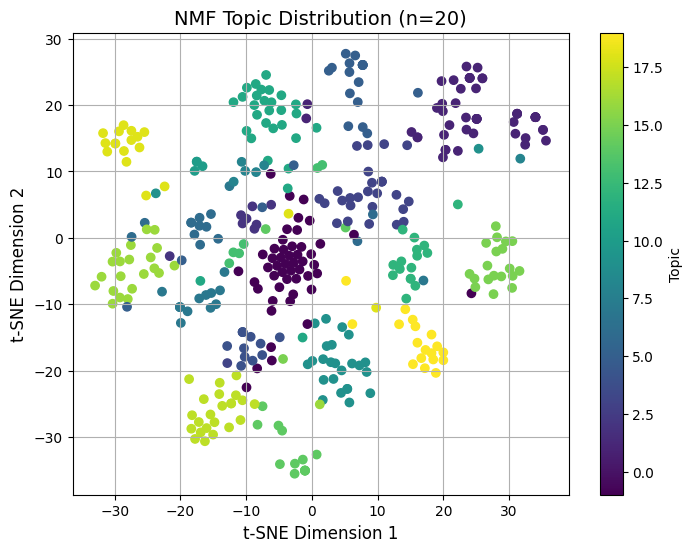

In [38]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(nmf_topics)

# Trực quan hóa
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cfs_topic['NMF_Topics'], cmap='viridis', marker='o')
plt.title('NMF Topic Distribution (n=20)', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(label='Topic')
plt.grid(True)
plt.show()


#### **K-means**
Các bước thực hiện

1.   Chọn n_clusters (số cụm) phù hợp bằng cách vẽ biểu đồ cho Davies-Bouldin Index và Silhouette Score.
2.   Xây dựng mô hình với n vừa chọn. Tìm ra các cụm.
3. Tính các chỉ số Davies-Bouldin Index và Silhouette Score
4. Gán nhãn cho mỗi cfs bằng tên cụm. Thêm cột nhãn vào df
5. Biểu diễn số lượng cfs cho mỗi cụm bằng biểu đồ cột.
6.  Biểu diễn trực quan bằng TSNE


n_clusters=5: Silhouette Score=0.08390104570228683, Davies-Bouldin Index=2.766443268803118
n_clusters=10: Silhouette Score=0.10018866193078957, Davies-Bouldin Index=2.244638212132126
n_clusters=15: Silhouette Score=0.13381062543707636, Davies-Bouldin Index=2.173107431872536
n_clusters=20: Silhouette Score=0.14253183992370208, Davies-Bouldin Index=2.1220048010903207
n_clusters=25: Silhouette Score=0.16065392921304647, Davies-Bouldin Index=1.9906060562044217
n_clusters=30: Silhouette Score=0.17804170358449276, Davies-Bouldin Index=1.8286452649938276
n_clusters=35: Silhouette Score=0.17697709441408838, Davies-Bouldin Index=1.7678348963171961
n_clusters=40: Silhouette Score=0.18560438128990234, Davies-Bouldin Index=1.6613841763838189
n_clusters=45: Silhouette Score=0.19207128369923068, Davies-Bouldin Index=1.590419735548215


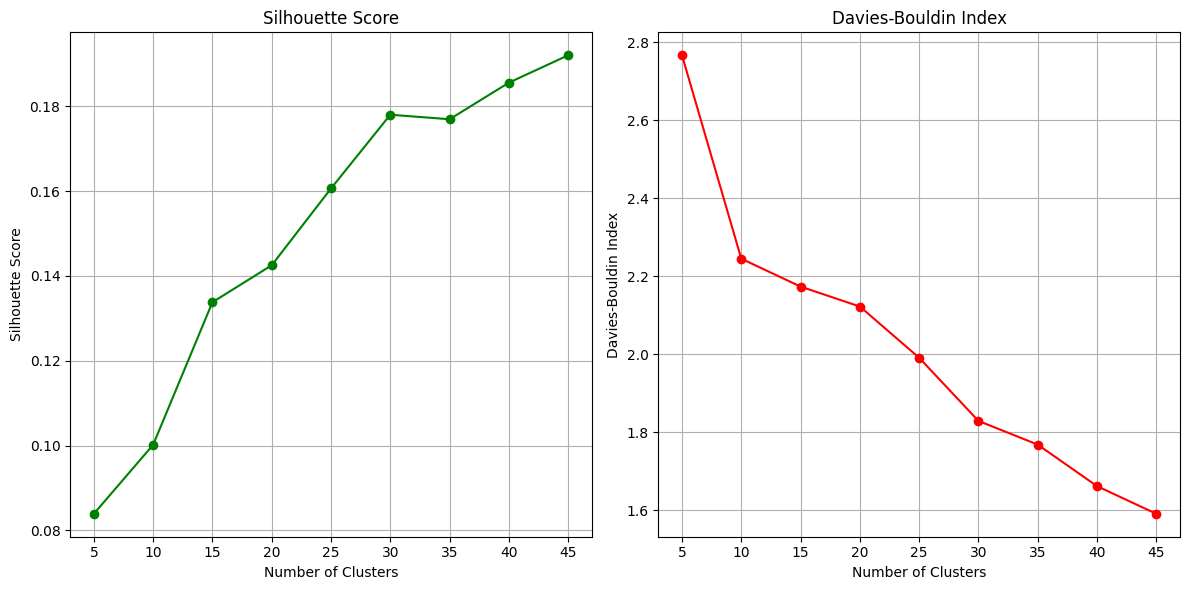

In [39]:
n_clusters_list = [5, 10, 15, 20, 25, 30, 35, 40, 45]

silhouettes = []
davies_bouldins = []

# Chạy mô hình KMeans với các số cụm khác nhau
for n in n_clusters_list:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_tfidf)

    # Tính Silhouette Score
    silhouette_avg = silhouette_score(X_tfidf, kmeans.labels_)
    silhouettes.append(silhouette_avg)

    # Tính Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
    davies_bouldins.append(davies_bouldin)

    print(f"n_clusters={n}: Silhouette Score={silhouette_avg}, Davies-Bouldin Index={davies_bouldin}")

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(n_clusters_list, silhouettes, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score', fontsize=12)
plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.grid(True)

# Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(n_clusters_list, davies_bouldins, marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index', fontsize=12)
plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Davies-Bouldin Index', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

*Davies-Bouldin Index giảm và Silhouette Score tăng với số cụm tăng dần. Chọn mức vừa phải.*

In [40]:
# Chọn n = 25
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
# Tính Silhouette Score
silhouette_K= silhouette_score(X_tfidf, kmeans.labels_)

# Tính Davies-Bouldin Index
davies_bouldin_K = davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)

print(f"n_clusters= 25: Silhouette Score={silhouette_K}, Davies-Bouldin Index={davies_bouldin_K}")

n_clusters= 25: Silhouette Score=0.16065392921304647, Davies-Bouldin Index=1.9906060562044217


In [41]:
# Gán nhãn vào cột Kmeans_Clusters
cfs_topic['Kmeans_Clusters'] = kmeans_labels

# Hiển thị kết quả
print( cfs_topic[['Processed_Text','Kmeans_Clusters']].head())

                                      Processed_Text  Kmeans_Clusters
0  chào anh_chị người may_mắn mùa_hè năm_ngoái tr...                4
1     thông_tin tên_người niên_khóa học khoa kế kiểm               24
2  chào cư_dân ueh confessions thông_tin chụp_ảnh...               15
3  tên_người niên_khóa quản_lý công đẹp_trai ngườ...               10
4                    trường_mình kí_túc_xá bách_khoa               16


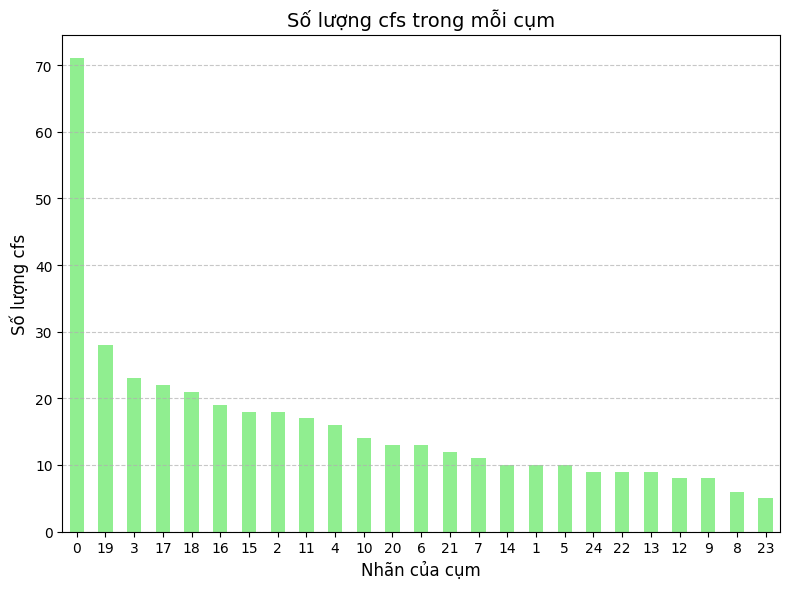

In [42]:
# Tính số lượng văn bản
topic_label_counts = cfs_topic['Kmeans_Clusters'].value_counts()

# Vẽ biểu đồ số lượng văn bản theo từng nhãn
plt.figure(figsize=(8, 6))
topic_label_counts.plot(kind='bar', color='lightgreen')
plt.title('Số lượng cfs trong mỗi cụm', fontsize=14)
plt.xlabel('Nhãn của cụm', fontsize=12)
plt.ylabel('Số lượng cfs', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

*Cụm có số cfs nhiều nhất là cụm 0, số lượng cfs trong các cụm khác đều ít hơn 30*

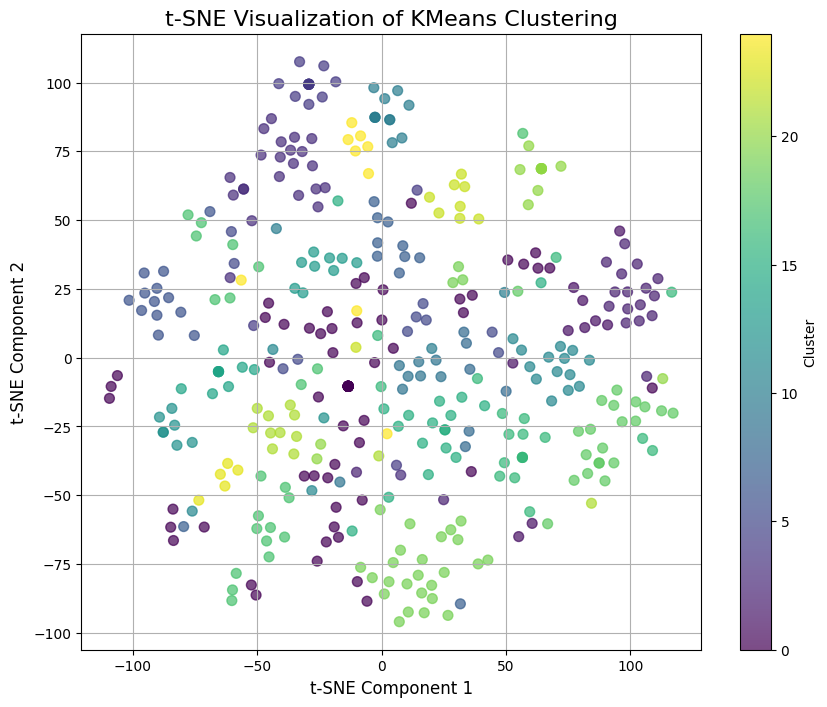

In [43]:
#  t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Vẽ kết quả phân cụm bằng t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('t-SNE Visualization of KMeans Clustering', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


### **3. Mô hình học sâu**

In [63]:
flattened_cfs

['chào anh_chị người may_mắn mùa_hè năm_ngoái trải_nghiệm mùa_hè xanh anh_chị anh_chị khóa in thân_thiết anh_chị tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người tên_người học cảm_nhận anh_chị gia_đình bảo anh_chị sự_cố_gắng ngừng vươn đậu vô trường_ueh anh_chị người_ngoài tên_người khắc_ghi tâm_trí quên tên_người cố_gắng học ueh chờ câu ngắn_gọn động_lực hi_vọng',
 'thông_tin tên_người niên_khóa học khoa kế kiểm',
 'chào cư_dân ueh confessions thông_tin chụp_ảnh ueh mentoring training chụp_ảnh đẹp xỉu',
 'tên_người niên_khóa quản_lý công đẹp_trai người_thương đón noel',
 'trường_mình kí_túc_xá bách_khoa',
 'chào anh_chị học ueh tiếng_anh bình_thường hơi ielts tầm hứng_thú tiếng_trung học tiếng_trung chán_nản học tiếng_anh học khuyên duy_trì tiếng_anh ôn ráng tập_trung_học tiếng_trung học tiếng_anh tiếng_trung học quyết_định tiếng_anh ngôn_ngữ việc_làm ngôn_ngữ anh_chị',
 'kinh_nghiệm kiến_thức lĩnh_vực tổ_chức talkshow diễn_giả giúp',
 'chê trai ueh ueh 

In [64]:
from bertopic import BERTopic

# Khởi tạo và huấn luyện mô hình BERTopic với dữ liệu đã vectorized (TF-IDF)
BERTopic_model = BERTopic(vectorizer_model=tfidf_vectorizer)
topics, probabilities = BERTopic_model.fit_transform(flattened_cfs)

In [46]:
# Gán nhãn topic cho từng cfs
cfs_topic['BERTopic_Topics'] = topics

# Quan sát 5 dòng đầu tiên của dữ liệu đã được gán nhãn
print(cfs_topic[['Processed_Text', 'BERTopic_Topics']].head())

                                      Processed_Text  BERTopic_Topics
0  chào anh_chị người may_mắn mùa_hè năm_ngoái tr...                0
1     thông_tin tên_người niên_khóa học khoa kế kiểm                4
2  chào cư_dân ueh confessions thông_tin chụp_ảnh...                2
3  tên_người niên_khóa quản_lý công đẹp_trai ngườ...                1
4                    trường_mình kí_túc_xá bách_khoa               -1


In [47]:
topic_label_counts = cfs_topic['BERTopic_Topics'].value_counts()
topic_label_counts

,count
BERTopic_Topics,
-1,195
0,68
1,58
2,23
3,18
4,17
5,11
6,10


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

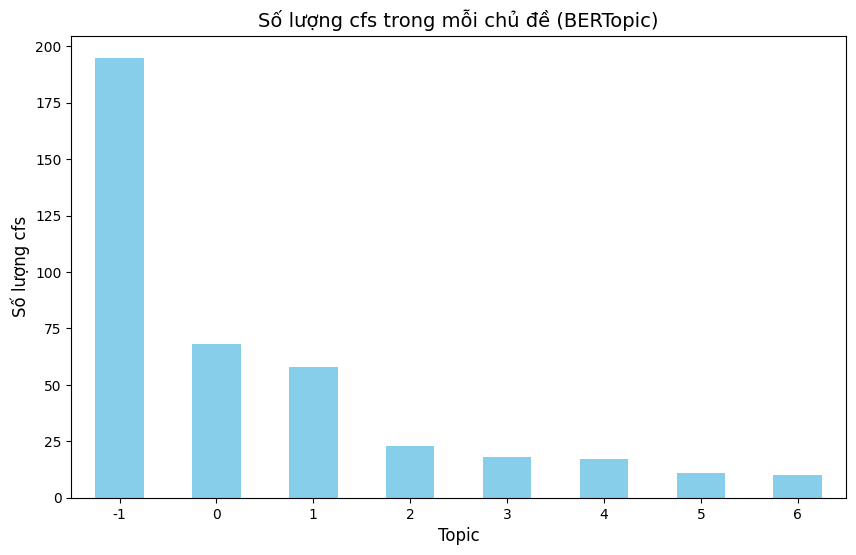

In [48]:
# Vẽ biểu đồ thể hiện số lượng từng topic
plt.figure(figsize=(10, 6))
topic_label_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng cfs trong mỗi chủ đề (BERTopic)', fontsize=14)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Số lượng cfs', fontsize=12)
plt.xticks(rotation=0)
plt

In [49]:
# Xem lại nội dung của từng topic, hiển thị 5 dòng đầu tiên của mỗi topic
for topic in topic_label_counts.index:
    print(f"Topic {topic}:")
    print(cfs_topic[cfs_topic['BERTopic_Topics'] == topic]['Processed_Text'].head(5))
    print('\n')

Topic -1:
4                      trường_mình kí_túc_xá bách_khoa
6    kinh_nghiệm kiến_thức lĩnh_vực tổ_chức talksho...
7    chê trai ueh ueh học giỏi đầu_vào trường năng_...
8                   chỗ thay pin máy_tính casio fx vnx
9                 trường_mình mẫu_ảnh book mẫu học ueh
Name: Processed_Text, dtype: object


Topic 0:
0     chào anh_chị người may_mắn mùa_hè năm_ngoái tr...
11    hai trôi ueh chênh_vênh trống_vắng áp_lực học_...
14    sinh_viên bạn_thân vi_vu nói_chuyện quan_hệ qu...
18    chào all đọc viết mạn_phép xưng all vô_định al...
22    nói_thẳng lớp_trưởng lớp tên_lớp vô trách_nhiệ...
Name: Processed_Text, dtype: object


Topic 1:
3     tên_người niên_khóa quản_lý công đẹp_trai ngườ...
13    tên_người quê quy nhơn niên_khóa khoa kinh_doa...
41    tên_người tên_lớp người_thương đẹp_trai trời g...
45     tên_người học ngành kinh_doanh quốc_tế người_yêu
49              tên_người niên_khóa quen người nhỏ_tuổi
Name: Processed_Text, dtype: object


Topic 2:
2     chào cư_

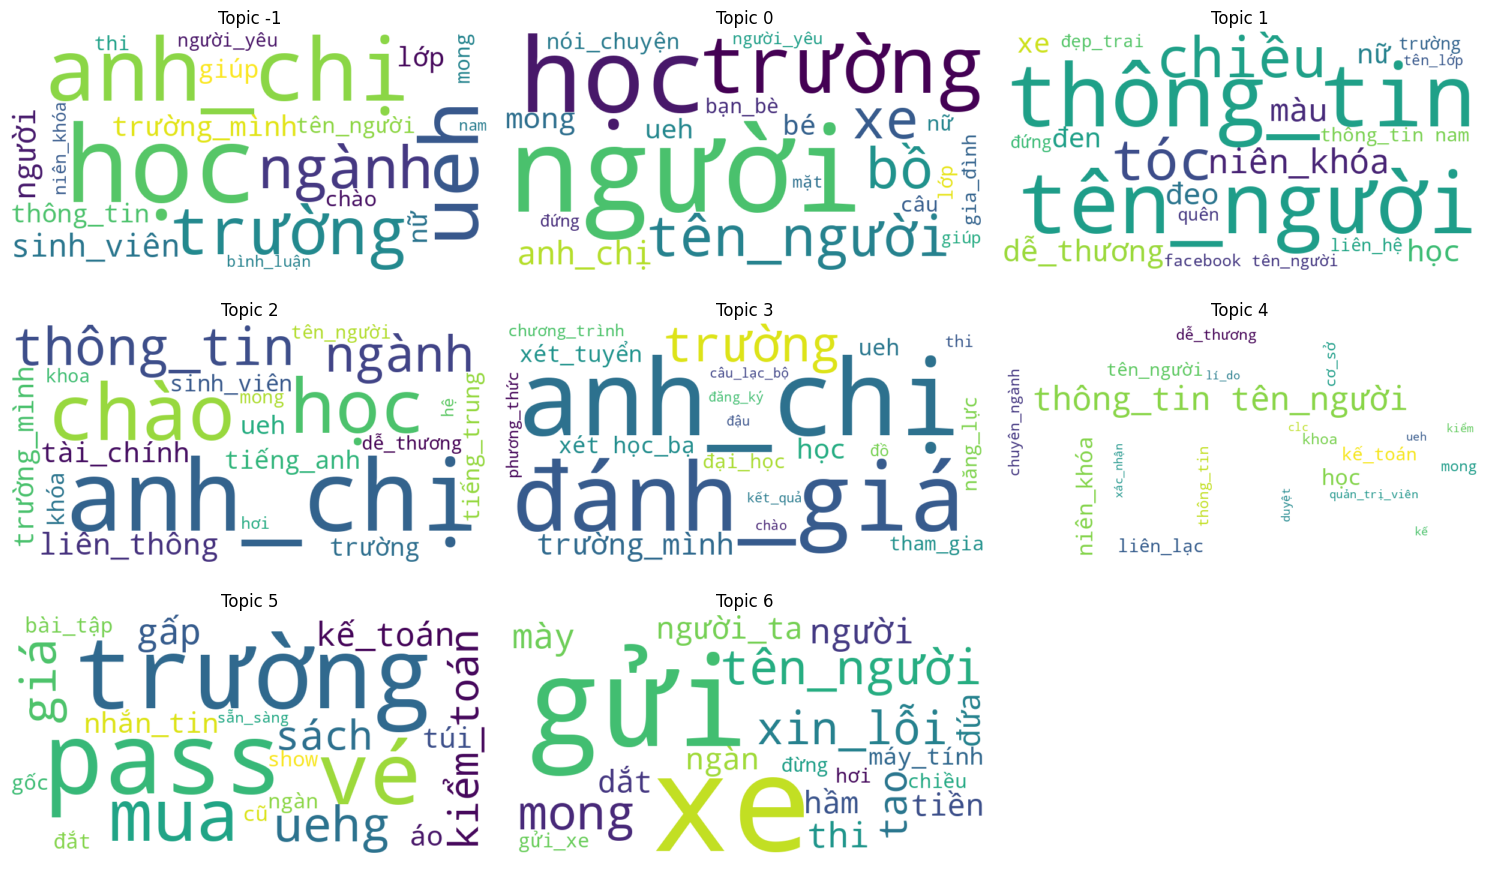

In [50]:
num_topics = len(topic_label_counts)
# Tạo subplot
fig, axes = plt.subplots(num_topics // 3 + (1 if num_topics % 3 > 0 else 0), 3, figsize=(15, 3 * (num_topics // 3 + (1 if num_topics % 3 > 0 else 0))))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, topic in enumerate(topic_label_counts.index):
    filtered_df = cfs_topic[cfs_topic['BERTopic_Topics'] == topic]
    text = " ".join(filtered_df['Processed_Text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color="white").generate(text)

    row = i // 3
    col = i % 3
    axes[row, col].imshow(wordcloud, interpolation="bilinear")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Topic {topic}")

for j in range(i + 1, num_topics // 3 * 3 + (3 if num_topics % 3 > 0 else 0)):
    row = j // 3
    col = j % 3
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

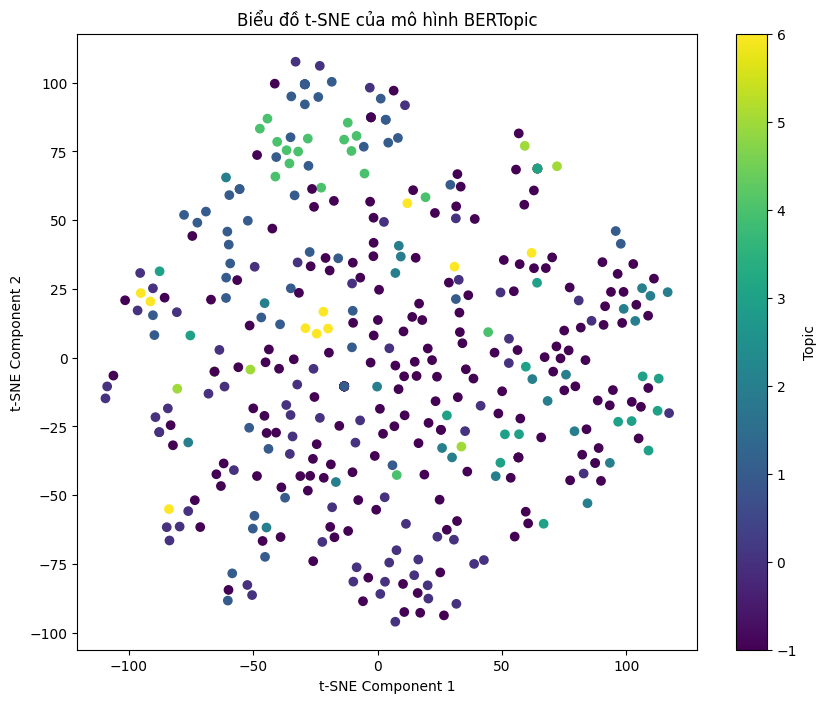

In [51]:
# Áp dụng t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Vẽ biểu đồ t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cfs_topic['BERTopic_Topics'])  # Sử dụng cột 'Topic' để tô màu
plt.colorbar(label='Topic')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Biểu đồ t-SNE của mô hình BERTopic')
plt.show()

In [52]:
# Giảm chiều xuống 3D với T-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(X_tfidf.toarray())

# Tạo DataFrame
df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y', 'z'])
df_tsne['Topic'] = cfs_topic['BERTopic_Topics']

# Vẽ biểu đồ 3D với Plotly Express
fig = px.scatter_3d(df_tsne, x='x', y='y', z='z', color='Topic',
                    title="Biểu đồ 3D t-SNE của mô hình BERTopic",
                    labels={'x': 'Trục 1', 'y': 'Trục 2', 'z': 'Trục 3'},
                    color_continuous_scale='Viridis')

# Hiển thị biểu đồ
fig.show()

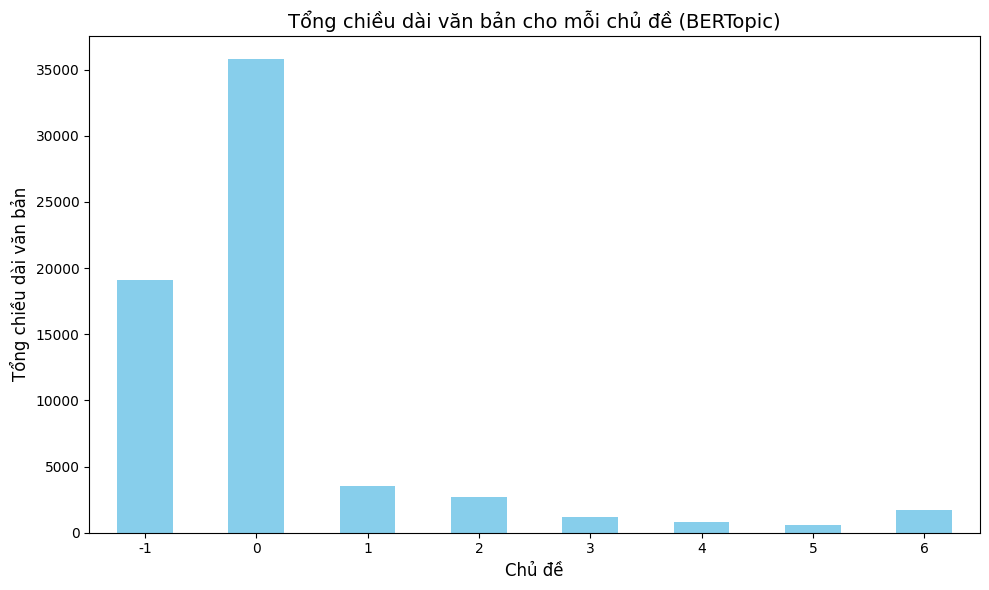

In [53]:
# Tính độ dài của văn bản cho mỗi topic
topic_text_lengths = cfs_topic.groupby('BERTopic_Topics')['Processed_Text'].apply(lambda x: x.str.len().sum())

# Tạo biểu đồ so sánh chiều dài văn bản giữa các Topic của mô hình BERTopic
plt.figure(figsize=(10, 6))
topic_text_lengths.plot(kind='bar', color='skyblue')
plt.title('Tổng chiều dài văn bản cho mỗi chủ đề (BERTopic)', fontsize=14)
plt.xlabel('Chủ đề', fontsize=12)
plt.ylabel('Tổng chiều dài văn bản', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

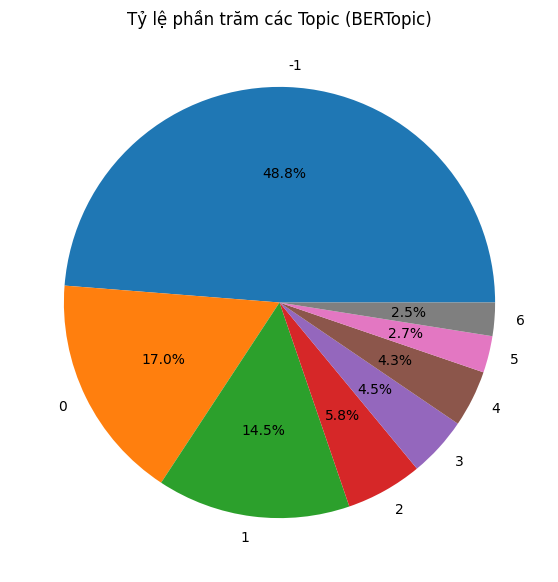

In [54]:
topic_label_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7))
plt.title("Tỷ lệ phần trăm các Topic (BERTopic)")
plt.ylabel("")
plt.show()

In [55]:
# Tính Silhouette Score
silhouette_BERTopic = silhouette_score(X_tfidf, cfs_topic['BERTopic_Topics'])

# Tính Davies-Bouldin Index
davies_bouldin_BERTopic = davies_bouldin_score(X_tfidf.toarray(), cfs_topic['BERTopic_Topics'])

# In kết quả
print(f"BERTopic:")
print(f"Silhouette Score: {silhouette_BERTopic}")
print(f"Davies-Bouldin Index: {davies_bouldin_BERTopic}")

BERTopic:
Silhouette Score: -0.04798175110719542
Davies-Bouldin Index: 4.973474238177451


_____________________________________________
# **V. Tổng kết**
_____________________________________________

In [56]:
# Kết quả từ các mô hình
LDA = [3, perplexityLDA, silhouetteLDA, davies_bouldinLDA]
NMF = [20, PerplexityNMF, silhouetteNMF, davies_bouldinNMF]
Kmeans = [25, None, silhouette_K, davies_bouldin_K]
BERTopic = [(len(BERTopic_model.get_topic_freq()) - 1), None, silhouette_BERTopic, davies_bouldin_BERTopic]
#Học sâu
# Tạo DataFrame
results = pd.DataFrame(
    {
        "Model": ["LDA", "NMF", "Kmeans", "BERTopic"],
        "Topics/Clusters": [LDA[0], NMF[0], Kmeans[0], BERTopic[0]],
        "Perplexity": [LDA[1], NMF[1], Kmeans[1], BERTopic[1]],
        "Silhouette Score": [LDA[2], NMF[2], Kmeans[2], BERTopic[2]],
        "Davies-Bouldin Index": [LDA[3], NMF[3], Kmeans[3], BERTopic[3]],
    }
)

# Hiển thị DataFrame
results

,Model,Topics/Clusters,Perplexity,Silhouette Score,Davies-Bouldin Index
0,LDA,3,72.617285,0.043175,4.443593
1,NMF,20,10.921672,0.110218,2.048731
2,Kmeans,25,NaN,0.160654,1.990606
3,BERTopic,7,NaN,-0.047982,4.973474


*Đánh giá bằng chỉ số mang tính tương đối*

In [59]:
#Lưu các cfs cùng các nhãn chủ đề/ cụm đã gán để xem xét ý nghĩa
cfs_topic.to_excel("Labelled_cfs.xlsx", index=False, engine='openpyxl')
print("Data saved to Labelled_cfs.xlsx")

Data saved to Labelled_cfs.xlsx
